# MSCI Kokusai Constituents Macro Factor Model Ver1

金利ファクター

$$
R = \alpha + \beta_{\mathrm{mkt}}r_{\mathrm{mkt}} + \beta_{\mathrm{level}}r_{\mathrm{level}}+ \beta_{\mathrm{slope}}r_{\mathrm{slope}}+ \beta_{\mathrm{curvature}}r_{\mathrm{curvature}} + \epsilon
$$

-   $\beta_{\mathrm{mkt}}$: マーケット(MSCI Kokusai)ベータ
-   $\beta_{\mathrm{level}}$: US 金利データを主成分分析したのちの第 1 主成分(level)によるベータ
-   $\beta_{\mathrm{slope}}$: 第 2 主成分(slope)によるベータ
-   $\beta_{\mathrm{curvature}}$: 第 3 主成分(curvature)によるベータ


In [152]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import polars as pl
from pathlib import Path
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import MultipleLocator
import statsmodels.api as sm
import seaborn as sns
import json
import os
import sys
from sklearn.decomposition import PCA
from dotenv import load_dotenv
from dateutil.relativedelta import relativedelta
from datetime import datetime, date, timedelta
from typing import List
from fredapi import Fred
from tqdm import tqdm
from data_check_utils import calculate_missing_stats, extract_dates_in_range
from database_utils import get_table_names, step1_load_file_to_db, step2_create_variable_tables, step3_create_return_table
from data_prepare import createDB_bpm_and_factset_code
from concurrent.futures import ThreadPoolExecutor

import warnings

warnings.simplefilter("ignore")


Q_DIR = Path().cwd().parent.parent
DATA_DIR = Q_DIR / "data" / "MSCI_KOKUSAI"
PRJ_DIR = Q_DIR / "A_001"
# Factset Benchmark directory
BM_DIR = Q_DIR / "data/Factset/Benchmark"
FRED_DIR = Path().cwd().parents[2] / "FRED"
print(f"FRED directory: {FRED_DIR}")


fred_module = str((FRED_DIR / "src").resolve())
if fred_module not in sys.path:
    sys.path.append(fred_module)
    print(f"{fred_module}をsys.pathに追加しました。")

from fred_database_utils import store_fred_database  # type: ignore
from us_treasury import (
    plot_us_interest_rates_and_spread,
    analyze_yield_curve_pca,
    plot_loadings_and_explained_variance,
    )

FRED_API = os.getenv("FRED_API_KEY")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
FRED directory: /Users/yukihata/Desktop/papers/FRED


## Load Data


In [ ]:
db_daily_price = DATA_DIR / "MSCI_KOKUSAI_and_BM_Daily_Price.db"
db_fred = FRED_DIR / "FRED.db"

df_price = pd.read_sql(
    "SELECT * FROM FG_PRICE_Daily ORDER BY P_SYMBOL, date",
    sqlite3.connect(db_daily_price),
    parse_dates=["date"],
).assign(log_value=lambda x: np.log(x["value"]))

# return data
df_return = (
    pd.pivot(df_price, index="date", columns="P_SYMBOL", values="log_value")
    .diff()
    .sort_index()
)
df_return = df_return.diff().dropna(how="all")

print("return data")
display(df_return)


# interest rates
table_list = [
    "DFF",
    "DGS1MO",
    "DGS3MO",
    "DGS6MO",
    "DGS1",
    "DGS2",
    "DGS3",
    "DGS5",
    "DGS7",
    "DGS10",
    "DGS20",
    "DGS30",
]
dfs_yield = []
for table in table_list:
    df = (
        pd.read_sql(
            f"SELECT * FROM {table}", sqlite3.connect(db_fred), parse_dates=["date"]
        )
        .assign(tenor=table)
        .rename(columns={table: "value"})
    )
    dfs_yield.append(df)

df_yield = (
    pd.pivot(
        pd.concat(dfs_yield, ignore_index=True),
        index="date",
        columns="tenor",
        values="value",
    )
    .sort_index()
    .reindex(columns=table_list)
)

print("yield data")
display(df_yield)


return data


P_SYMBOL,0HSW-GB,0II3.XX1-GB,0MDJ-GB,0N1N-GB,0N3I-GB,0O2E-GB,0P1Q-GB,0P6A-GB,0P7J-GB,0UAN-GB,...,ZFX-AU,ZG-US,ZIGGO-NL,ZIM-US,ZION-US,ZM-US,ZOT-ES,ZS-US,ZTS-US,ZURN-CH
date,,,,,,,,,,,,,,,,,,,,,
2005-08-24,0.002566,-0.006118,-0.001812,-0.012325,-0.004655,0.010327,0.013603,-0.015894,-0.005457,-0.013073,...,-0.000257,NaN,NaN,NaN,0.006173,NaN,-0.014794,NaN,NaN,0.004660
2005-08-25,0.021599,-0.008693,-0.022622,0.006022,0.016260,0.000000,-0.013631,0.001304,-0.015913,-0.007244,...,-0.037193,NaN,NaN,NaN,0.005376,NaN,0.008517,NaN,NaN,0.002123
2005-08-26,-0.023263,0.022257,0.019928,0.018679,0.007239,-0.002599,0.015351,0.005138,0.020717,0.017692,...,0.050419,NaN,NaN,NaN,-0.016344,NaN,-0.002693,NaN,NaN,0.004454
2005-08-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.010303,NaN,NaN,NaN,0.030704,NaN,-0.008939,NaN,NaN,0.003614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002299,...,NaN,-0.005281,NaN,-0.012892,-0.018997,0.025004,NaN,0.039292,0.002778,-0.012302
2025-08-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-08-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.006570,...,NaN,-0.021017,NaN,0.024848,0.014415,0.019471,NaN,0.003582,-0.014777,0.012145


yield data


tenor,DFF,DGS1MO,DGS3MO,DGS6MO,DGS1,DGS2,DGS3,DGS5,DGS7,DGS10,DGS20,DGS30
date,,,,,,,,,,,,
1954-07-01,1.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1954-07-02,1.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1954-07-03,1.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1954-07-04,1.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1954-07-05,0.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-17,4.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-08-18,4.33,4.47,4.33,4.13,3.93,3.77,3.73,3.86,4.07,4.34,4.92,4.94
2025-08-19,4.33,4.46,4.30,4.11,3.91,3.75,3.70,3.82,4.04,4.30,4.89,4.90


### 金利変動幅に対して PCA


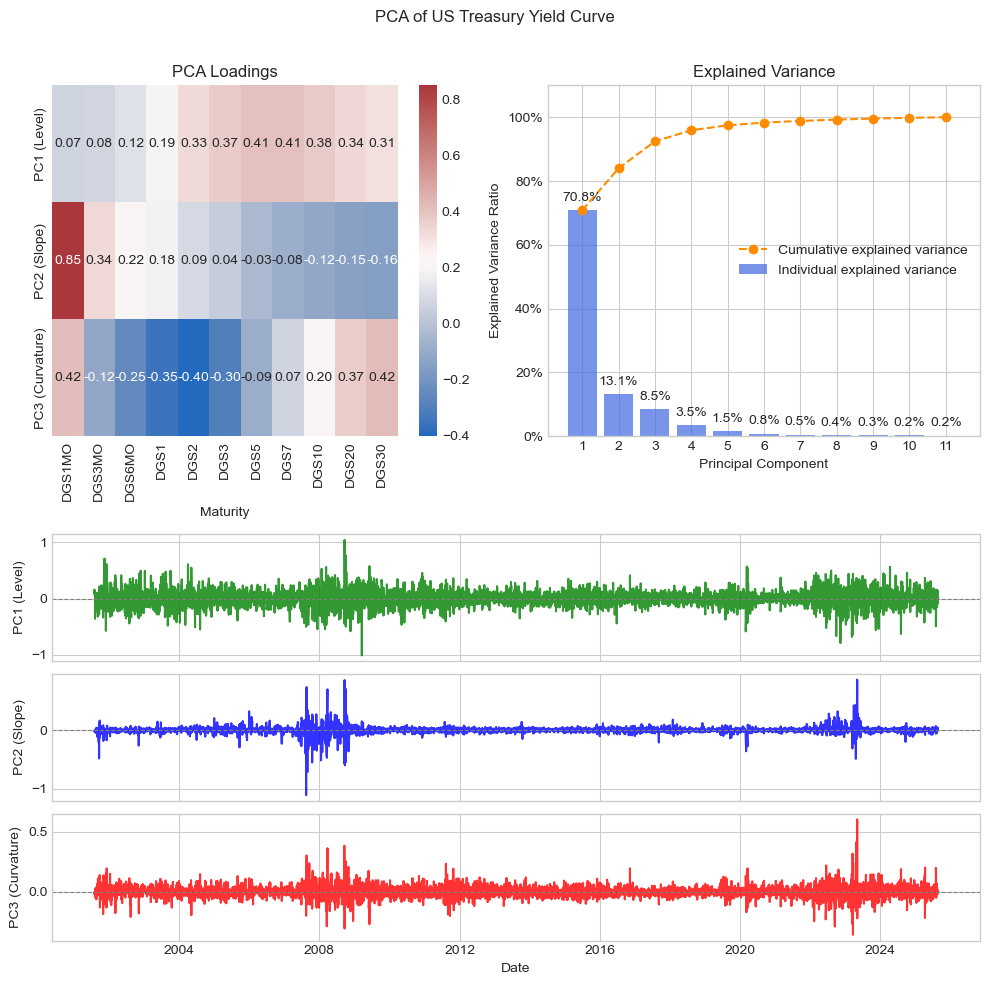

In [ ]:
df_yield_copy = df_yield.copy()
df_yield_copy.drop(columns=["DFF"], inplace=True)
df_yield_diff = df_yield_copy.diff().dropna(how="any")
# display(df_yield_diff)
plot_loadings_and_explained_variance(df_original=df_yield_diff)


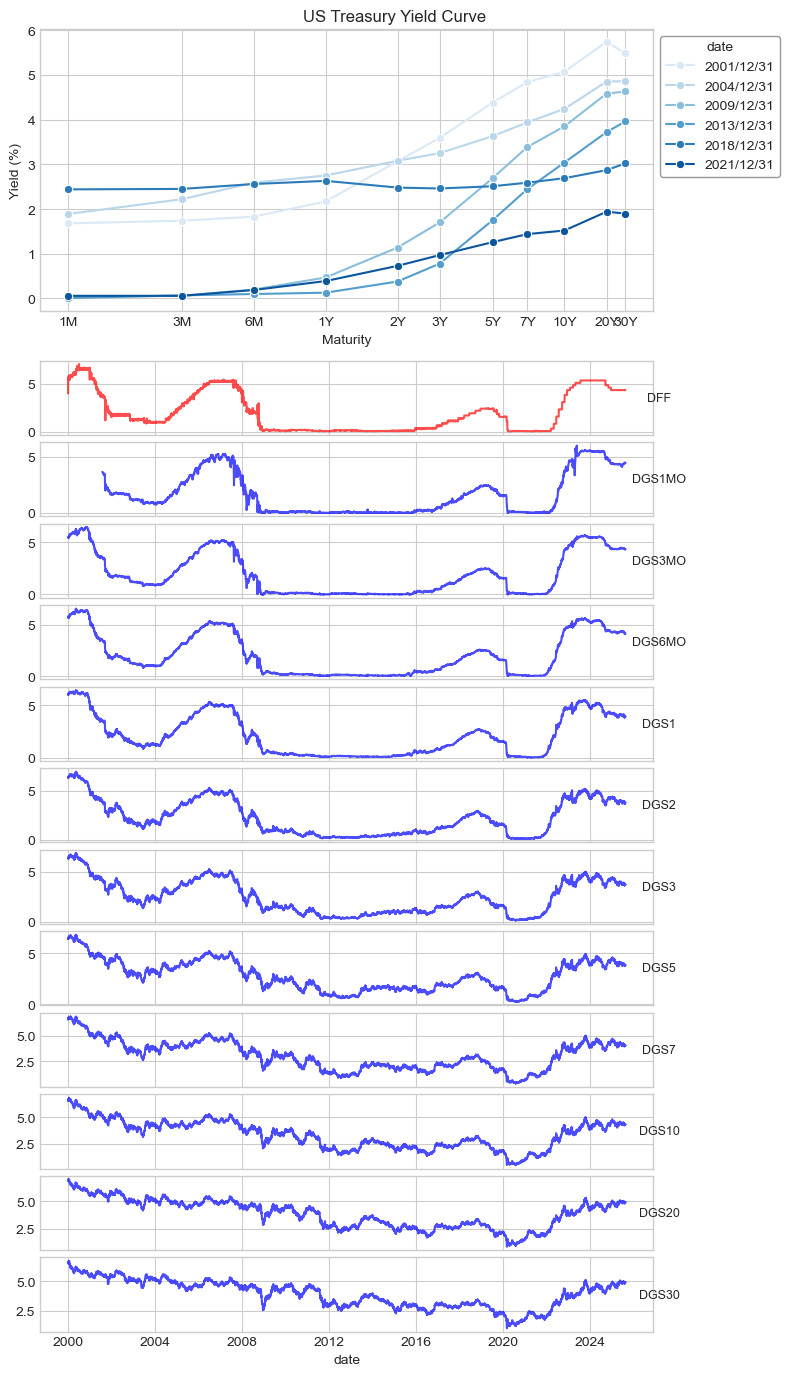

In [ ]:
df_yield_ann = df_yield_copy.groupby(df_yield_copy.index.year).tail(1).dropna(how="any")

# === plot ===
fig = plt.figure(figsize=(8, 14), tight_layout=True)
fig.suptitle("US Treasury Yield Curve")
# --- GridSpec ---
num_maturity = len(df_yield.columns.tolist())
gs_master = gridspec.GridSpec(
    num_maturity + 1, 1, figure=fig, height_ratios=[8] + [1] * num_maturity
)
# yield curve
gs_yield_curve = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_master[0, 0])
ax_yield_curve = fig.add_subplot(gs_yield_curve[0, 0])
# yield curve time series(line chart)
gs_time_series = gridspec.GridSpecFromSubplotSpec(
    num_maturity, 1, subplot_spec=gs_master[1:, 0], hspace=0.1
)


# --- x axis ticks ---
xticks = [
    1,
    3,
    6,
    1 * 12,
    2 * 12,
    3 * 12,
    5 * 12,
    7 * 12,
    10 * 12,
    15 * 12,
    18 * 12,
]
xlabels = ["1M", "3M", "6M", "1Y", "2Y", "3Y", "5Y", "7Y", "10Y", "20Y", "30Y"]


date_list = df_yield_ann.index[::3]
palette = sns.color_palette("Blues", n_colors=len(date_list))
for i, date in enumerate(date_list):
    df_slice = pd.DataFrame(df_yield_ann.loc[date].T)
    sns.lineplot(
        df_slice,
        x=xticks,
        y=df_slice.values.flatten(),
        ax=ax_yield_curve,
        marker="o",
        label=date.strftime("%Y/%m/%d"),
        color=palette[i],
    )
ax_yield_curve.set_xscale("log")
ax_yield_curve.set_xticks(xticks)
ax_yield_curve.set_xticklabels(xlabels)
ax_yield_curve.set_xlabel("Maturity")
ax_yield_curve.set_ylabel("Yield (%)")
ax_yield_curve.legend(
    bbox_to_anchor=(1, 1), title="date", frameon=True, edgecolor="grey"
)

ax_ref = None
df_to_plot = df_yield.loc["2000-01-01":]
for i, maturity in enumerate(df_to_plot.columns.tolist()):
    if i == 0:
        ax = fig.add_subplot(gs_time_series[i, 0])
        ax_ref = ax
    else:
        ax = fig.add_subplot(gs_time_series[i, 0], sharex=ax_ref)
    color = "red" if maturity == "DFF" else "blue"
    sns.lineplot(
        data=df_to_plot,
        x=df_to_plot.index,
        y=df_to_plot.iloc[:, i],
        ax=ax,
        alpha=0.7,
        color=color,
    )
    ax.set_ylabel("")
    ax.text(
        1.01,
        0.5,
        maturity,
        transform=ax.transAxes,
        va="center",
        ha="center",
        fontsize=9,
    )
    if i < num_maturity - 1:
        ax.set_xlabel("")
        ax.tick_params(labelbottom=False)
    else:
        ax.set_xlabel("date")

plt.show()


## 金利ファクター


In [ ]:
# index return
kokusai_return = df_return[["MSCI Kokusai Index (World ex Japan)"]]
display(kokusai_return.head())

# 個別銘柄 return
df_return_ex_benchmark = df_return.drop(
    columns=["MSCI Kokusai Index (World ex Japan)", "S&P 500"]
)
display(df_return_ex_benchmark.head())


# yield diff pca
df_pca, _ = analyze_yield_curve_pca(df_yield)
display(df_pca.head())

# merge
symbol = "MSCI-US"
df_merged = pd.merge(
    kokusai_return, df_return_ex_benchmark[[symbol]], left_index=True, right_index=True
)
df_merged = pd.merge(df_merged, df_pca, left_index=True, right_index=True).dropna(
    how="any", ignore_index=True
)
display(df_merged.head())


# OLS
X = df_merged[["MSCI Kokusai Index (World ex Japan)", "PC1", "PC2", "PC3"]]
Y = df_merged[symbol]

X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()

print(model.summary())


P_SYMBOL,MSCI Kokusai Index (World ex Japan)
date,
2005-08-24,-0.000737
2005-08-25,0.004001
2005-08-26,-0.004809
2005-08-30,NaN
2005-08-31,0.009994


P_SYMBOL,0HSW-GB,0II3.XX1-GB,0MDJ-GB,0N1N-GB,0N3I-GB,0O2E-GB,0P1Q-GB,0P6A-GB,0P7J-GB,0UAN-GB,...,ZFX-AU,ZG-US,ZIGGO-NL,ZIM-US,ZION-US,ZM-US,ZOT-ES,ZS-US,ZTS-US,ZURN-CH
date,,,,,,,,,,,,,,,,,,,,,
2005-08-24,0.002566,-0.006118,-0.001812,-0.012325,-0.004655,0.010327,0.013603,-0.015894,-0.005457,-0.013073,...,-0.000257,NaN,NaN,NaN,0.006173,NaN,-0.014794,NaN,NaN,0.004660
2005-08-25,0.021599,-0.008693,-0.022622,0.006022,0.016260,0.000000,-0.013631,0.001304,-0.015913,-0.007244,...,-0.037193,NaN,NaN,NaN,0.005376,NaN,0.008517,NaN,NaN,0.002123
2005-08-26,-0.023263,0.022257,0.019928,0.018679,0.007239,-0.002599,0.015351,0.005138,0.020717,0.017692,...,0.050419,NaN,NaN,NaN,-0.016344,NaN,-0.002693,NaN,NaN,0.004454
2005-08-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.010303,NaN,NaN,NaN,0.030704,NaN,-0.008939,NaN,NaN,0.003614


,PC1,PC2,PC3
date,,,
2001-08-01,0.096153,-0.035078,-0.002266
2001-08-02,0.162758,-0.092878,-0.056155
2001-08-03,0.072261,-0.004946,0.024743
2001-08-07,0.036524,-0.021911,-0.031254
2001-08-08,-0.358527,0.045195,0.046641


,MSCI Kokusai Index (World ex Japan),MSCI-US,PC1,PC2,PC3
0,-0.024954,-0.084014,-0.278576,-0.132274,0.152148
1,0.019098,0.041731,0.256030,-0.009767,0.223635
2,-0.020763,-0.011791,-0.253751,-0.075424,0.122978
3,0.004860,0.012739,0.077269,0.264375,-0.128233
4,0.023668,-0.050548,0.050200,-0.151323,-0.109307


                            OLS Regression Results                            
Dep. Variable:                MSCI-US   R-squared:                       0.372
Model:                            OLS   Adj. R-squared:                  0.371
Method:                 Least Squares   F-statistic:                     383.3
Date:                Tue, 26 Aug 2025   Prob (F-statistic):          1.38e-259
Time:                        14:20:45   Log-Likelihood:                 5748.6
No. Observations:                2596   AIC:                        -1.149e+04
Df Residuals:                    2591   BIC:                        -1.146e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

### 決定係数が閾値を超える銘柄を特定する。


In [ ]:
# index return
kokusai_return = df_return[["MSCI Kokusai Index (World ex Japan)"]]
# 個別銘柄 return
df_return_ex_benchmark = df_return.drop(
    columns=["MSCI Kokusai Index (World ex Japan)", "S&P 500"]
)
# yield diff pca
df_pca, _ = analyze_yield_curve_pca(df_yield)

# merge
symbol_list = []
model_list = []
threshold_r_squared = 0.3
for symbol in tqdm(df_return_ex_benchmark.columns.tolist()):
    df_merged = pd.merge(
        kokusai_return,
        df_return_ex_benchmark[[symbol]],
        left_index=True,
        right_index=True,
    )
    df_merged = pd.merge(df_merged, df_pca, left_index=True, right_index=True).dropna(
        how="any", ignore_index=True
    )

    if not len(df_merged) == 0:
        # OLS
        X = df_merged[["MSCI Kokusai Index (World ex Japan)", "PC1", "PC2", "PC3"]]
        Y = df_merged[symbol]

        X = sm.add_constant(X)
        model = sm.OLS(Y, X).fit()

        r_squared = model.rsquared
        if r_squared >= threshold_r_squared:
            symbol_list.append(symbol)
            model_list.append(model)

print(
    f"決定係数が{int(threshold_r_squared*10)}割を超える銘柄が{len(symbol_list)}銘柄ありました。"
)


100%|██████████| 3262/3262 [00:06<00:00, 481.54it/s]

決定係数が3割を超える銘柄が586銘柄ありました。


In [ ]:
print(symbol_list)


['A-US', 'AA-US', 'AAL-US', 'AAPL-US', 'ABNB-US', 'ABT-US', 'ACGL-US', 'ACM-US', 'ACN-US', 'ACS-US', 'ADBE-US', 'ADI-US', 'ADM-US', 'ADP-US', 'ADSK-US', 'AER-US', 'AES-US', 'AFG-US', 'AFL-US', 'AFRM-US', 'AGCO-US', 'AGN.XX2-US', 'AIZ-US', 'AJG-US', 'AKS-US', 'ALB-US', 'ALL-US', 'ALLE-US', 'ALLY-US', 'ALV-US', 'AMAT-US', 'AMCR-US', 'AME-US', 'AMG-US', 'AMP-US', 'AMT-US', 'AMTD.XX1-US', 'AMZN-US', 'AN-US', 'ANDV-US', 'ANSS-US', 'AON-US', 'AOS-US', 'APC-US', 'APD-US', 'APH-US', 'APO-US', 'APTV-US', 'ARE-US', 'ARES-US', 'ARG-US', 'ARW-US', 'ASB-US', 'ASH-US', 'ATH-US', 'ATI-US', 'AVB-US', 'AVE-FR', 'AVGO-US', 'AVT-US', 'AVTR-US', 'AVY-US', 'AW-US', 'AXP-US', 'AXS-US', 'AXTA-US', 'AYE-US', 'AYI-US', 'BA-US', 'BAC-US', 'BALL-US', 'BAM-CA', 'BC-US', 'BDK-US', 'BEAM.XX3-US', 'BEAV-US', 'BEN-US', 'BFH-US', 'BHF-US', 'BJS-US', 'BK-US', 'BKR-US', 'BLK-US', 'BMO-CA', 'BN-CA', 'BNI-US', 'BNS-CA', 'BPYU-US', 'BR-US', 'BRK.B-US', 'BRO-US', 'BRX-US', 'BSY-US', 'BUCY-US', 'BWA-US', 'BX-US', 'BXP-US', '

In [ ]:
display(model_list[0].resid)
print(model_list[0].summary())


0       0.012469
1       0.019480
2      -0.005147
3      -0.031703
4       0.005833
          ...   
2919    0.005245
2920   -0.033339
2921    0.017628
2922   -0.028154
2923   -0.006146
Length: 2924, dtype: float64

                            OLS Regression Results                            
Dep. Variable:                   A-US   R-squared:                       0.457
Model:                            OLS   Adj. R-squared:                  0.457
Method:                 Least Squares   F-statistic:                     614.8
Date:                Tue, 26 Aug 2025   Prob (F-statistic):               0.00
Time:                        14:34:54   Log-Likelihood:                 7203.6
No. Observations:                2924   AIC:                        -1.440e+04
Df Residuals:                    2919   BIC:                        -1.437e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co